# Check output of SMICA for residuals, on map and powerspectrum level 

## Header

In [1]:
%%capture
import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import json
 
import copy
from astropy.io import fits
from scipy import interpolate

import healpy as hp
import component_separation
from component_separation.io import IO
import component_separation.interface as cslib
import component_separation.MSC.MSC.pospace as ps
import component_separation.powspec as pw

from component_separation.cs_util import Config
from component_separation.cs_util import Constants as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Planckf, Planckr, Plancks
import matplotlib.pyplot as plt
csu = Config()
io = IO(csu)
import warnings
warnings.filterwarnings('ignore')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

lmax=csu.lmax
nside_out = csu.nside_out
bins = csu.bins
detector = csu.PLANCKMAPFREQ_f
specfilter = csu.specfilter
freqfilter = csu.freqfilter
colors=csu.CB_color_cycle
bcorr = [
    hp.gauss_beam(val, lmax, pol = True)[:,1]
    for val in [
        0.00930842,
        0.00785398,
        0.00378155,
        0.002807071,
        0.002106031,
        0.00145444,
        0.00140499,
        ]
    ]
beam5 = hp.gauss_beam(0.00145444, lmax, pol = True)[:,1]

In [2]:
CMB_n = io.load_data(io.fh.map_cmb_sc_path_name)
MV_n = io.load_data(io.fh.cmbmap_smica_path_name)
smica_cmb_cl = io.load_data(io.fh.cmb_specsmica_sc_path_name)

W_smica = io.load_data(io.fh.weight_smica_path_name)
W_mv = io.load_data(io.fh.weight_path_name)

# cfc = copy.deepcopy(csu.cf)
# cfc['pa']['freqdset'] = 'DX12'
# csuc = Config(cfc)
# ioc = IO(csuc)

# CMB_d = ioc.load_data(ioc.fh.map_cmb_sc_path_name)
# MV_d = ioc.load_data(ioc.fh.cmbmap_smica_path_name)

pure_cmb_cl = io.load_data(io.fh.signal_sc_path_name)
pure_cmb_map = io.load_data(io.fh.map_cmb_sc_path_name)
smica_cmb_cl = io.load_data(io.fh.cmb_specsmica_sc_path_name)
smica_gal_cl = io.load_data(io.fh.gal_specsmica_sc_path_name)
smica_gal_mixmat = io.load_data(io.fh.out_specsmica_path+"gal_mixmat_{}".format("SMICA_lowell_bins") + "_" + io.fh.total_filename)

C_ltot = io.load_powerspectra('full')
cov_ltot = pw.build_covmatrices(C_ltot, csu.Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)
cov_ltotEE = cov_ltot[1]
print(cov_ltotEE.shape)

C_lN = io.load_powerspectra('noise')
cov_lN = pw.build_covmatrices(C_lN, csu.Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)
cov_lNEE = cov_lN[1]
for n in range(cov_lNEE.shape[0]):
    for m in range(cov_lNEE.shape[1]):
        if n != m:
            cov_lNEE[n,m] = np.zeros(shape=cov_lNEE.shape[2])
print(cov_lNEE.shape)

loaded /global/cscratch1/sd/sebibel/misc/map_cmb_in_nside_2048_sim_id_0200.npy
loaded /global/cscratch1/sd/sebibel/smica/smicaminvarmap_SMICA_highell_bins_0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/smica/NPIPE/CMB_SPECSMICA_SMICA_highell_bins0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/smica/SMICAWEIG_K_CMB_SMICA_highell_bins0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/weights/NPIPE/WEIG_K_CMB_0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/misc/C_lS_in_sim_id_0200.npy
loaded /global/cscratch1/sd/sebibel/misc/map_cmb_in_nside_2048_sim_id_0200.npy
loaded /global/cscratch1/sd/sebibel/smica/NPIPE/CMB_SPECSMICA_SMICA_highell_bins0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/smica/NPIPE/GAL_SPECSMICA_SMICA_highell_bins0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/smica/NPIPE/gal_mixmat_S

## Load Maudes DX12 results

In [4]:
md_N = np.loadtxt("/global/homes/s/sebibel/data/maude/N.txt").reshape(7,37)
md_A = np.loadtxt("/global/homes/s/sebibel/data/maude/A.txt").reshape(7,7)

md_P = np.loadtxt("/global/homes/s/sebibel/data/maude/P.txt").reshape(7,7,37)

md_hR = np.loadtxt("/global/homes/s/sebibel/data/maude/hR_binned_full.txt").reshape(7,7,37)
md_Rl = np.loadtxt("/global/homes/s/sebibel/data/maude/Rl.txt").reshape(7,7,4001)

md_w_raw = np.loadtxt("/global/homes/s/sebibel/data/maude/raw_filter_cmb_full.txt").reshape(2,7,4001)
md_w_mc = np.loadtxt("/global/homes/s/sebibel/data/maude/mc_filter_cmb_full.txt").reshape(2,7,4001)
md_w = np.loadtxt("/global/homes/s/sebibel/data/maude/w_binned_full.txt")

md_bins = np.loadtxt("/global/homes/s/sebibel/data/maude/bins.txt")

## Covariance

(7, 7, 37)


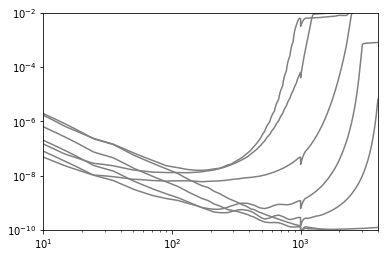

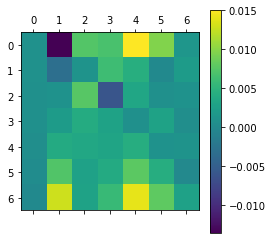

In [262]:
print(md_P.shape)
for n in range(md_P.shape[0]):
    plt.plot(md_Rl[n,n,:], color='gray')
#     plt.plot(np.mean(bins, axis=1), md_R[n,n,:])
#     plt.plot(np.mean(bins, axis=1), md_hR[n,n,:])
plt.yscale('log')
plt.xscale('log')
plt.xlim((1e1,4e3))
plt.ylim((1e-10,1e-2))
plt.show()

plt.matshow(md_A)
plt.colorbar()

## Bins

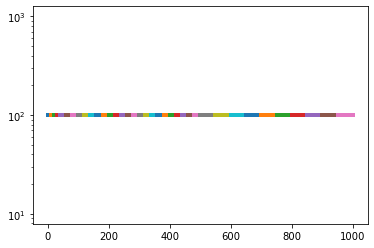

In [5]:
for n in range(md_bins[:].shape[0]):
    plt.plot(md_bins[n,:], [1e2,1e2], lw=4)
plt.yscale('log')

W_smica = io.load_data(io.fh.weight_smica_path_name)## Weights
 * "- raw_filter_cmb_full.txt: weights derived from the fit (A^T R-1 A)^-1 A^T R^-1" - what is A here?
 * md_w_mc looks familiar
 * md_w = what is that?

In [93]:
W_smica = io.load_data(io.fh.weight_smica_path_name)
W_data = io.load_data(io.fh.weight_path_name)

loaded /global/cscratch1/sd/sebibel/smica/SMICAWEIG_K_CMB_SMICA_highell_bins0200_C_l_DX12_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/weights/DX12/WEIG_K_CMB_0200_C_l_DX12_smica_4000_6000_0_0_Full.npy


In [98]:
%matplotlib widget
print(md_w_raw.shape)
print(md_w_mc.shape)
print(md_w.shape)
for freq in range(md_P.shape[0]):
#     pass
#     plt.plot(md_w_raw[0,n,:])
    plt.plot(md_w_mc[0,freq,:]*bcorr[freq]/(beam5), color=colors[freq], lw=3)
    #This is the fitting result
    plt.plot(np.mean(bins, axis=1), W_smica[0,freq,:], color=colors[freq], label=csu.PLANCKMAPFREQ[freq], lw=1, ls='-')
    plt.plot(np.mean(bins, axis=1), W_smica[1,freq,:], color=colors[freq], lw=1, ls='--')
# plt.plot(np.mean(bins, axis=1), md_w)
# plt.yscale('log')
plt.show()

(2, 7, 4001)
(2, 7, 4001)
(37,)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Calculate

In [150]:
md_R = np.zeros(shape=(7,7,37))
AP = np.zeros(shape=(7,7,37))
for l in range(0,37):
    AP[:,:,l] = np.dot(md_A, md_P[:,:,l])
    md_R[:,:,l] = np.dot(AP[:,:,l], md_A.T)
for l in range(0,37):
    for n in range(0,7):
        md_R[n,n,l] += md_N[n,l]

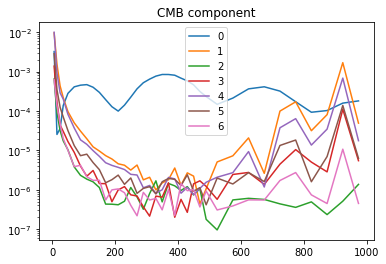

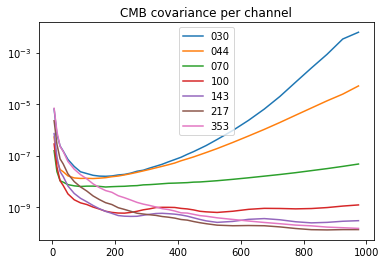

In [253]:
for n in range(md_P.shape[0]):
    plt.plot(np.mean(bins, axis=1), md_P[n,n,:], label=n)
plt.legend()
plt.title('CMB component')
plt.yscale('log')
plt.show()

for n in range(md_R.shape[0]):
    plt.plot(np.mean(bins, axis=1), md_R[n,n,:], label=csu.PLANCKMAPFREQ[n])
plt.legend()
plt.title('CMB covariance per channel')
plt.yscale('log')

## (A^T R-1 A)^-1 A^T R^-1

In [234]:
w = np.zeros(shape=(7,7,37))
a = np.ones(shape=(7))
a = md_A
for l in range(0,37):
    nom = np.linalg.inv(md_R[:,:,l]) @ a.T 
    denom = a.T @ np.linalg.inv(md_R[:,:,l]) @ a
    w[:,:,l] = nom / denom

(-10.0, 10.0)

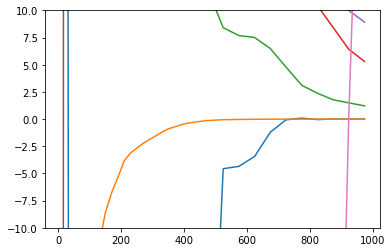

In [238]:
for n in range(7):
    plt.plot(np.mean(bins, axis=1), w[n,n])
plt.ylim((-10,10))

## W_ell hR_ell W_ell^T

In [258]:
lmaxbin = lmax#len(bins)
res_tot = np.zeros(shape=(lmaxbin))
for l in range(lmaxbin):
    res_tot[l] = np.dot(np.dot(md_w_mc[0,:,l].T,md_Rl[:,:,l]),md_w_mc[0,:,l])

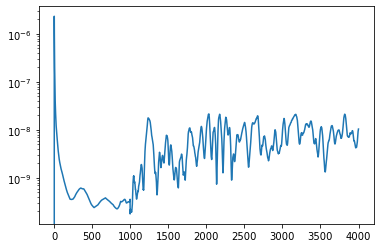

In [259]:
plt.plot(res_tot)
plt.yscale('log')

In [21]:
lmaxbin = int(bins[-1][1]+1)
W_total = np.zeros(shape=(*W_mv.shape[:-1], csu.lmax+1))
xnew = np.arange(0,lmaxbin+1,1)
for it, det in enumerate(csu.PLANCKMAPFREQ): #weights do not depend on freqfilter, but almE/B do
    if det in csu.PLANCKMAPFREQ_f:
        ns = csu.nside_out[0] if int(det) < 100 else csu.nside_out[1]
        W_Einterp = interpolate.interp1d(np.mean(bins, axis=1), W_smica[0,it,:], bounds_error = False, fill_value='extrapolate')
        W_total[1,it] = np.concatenate((W_Einterp(xnew),W_mv[1,it,xnew.shape[0]:]))

030
044
070
100
143
217
353


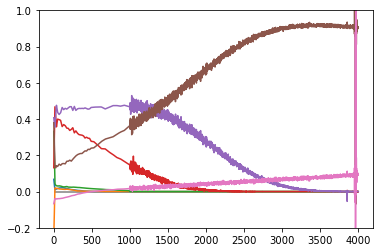

In [110]:
for freq in range(0, 7):
    freqc = '-'.join([csu.PLANCKMAPFREQ[freq],csu.PLANCKMAPFREQ[freq]])
    print(csu.PLANCKMAPFREQ[freq])
    plt.plot(W_total[1,freq,:])
plt.ylim((-0.2,1))
plt.hlines(0,lmax,0, color='grey')

In [8]:
print(smica_gal_cl.shape)
print(smica_gal_mixmat.shape)
print(W_total.shape)
print(W_smica.shape)
print(cov_ltotEE.shape)
print(W_total[1].shape)
print(smica_cmb_cl.shape)

(6, 6, 37)
(7, 6)
(9, 7, 4001)
(1, 7, 37)
(7, 7, 4001)
(7, 4001)
(1, 1, 37)


In [5]:
res_tot = np.zeros(shape=(lmax+1))
res_N = np.zeros(shape=(lmax+1))
for l in range(lmax+1):
    res_tot[l] = np.dot(np.dot(W_total[0,:,l].T,cov_ltotEE[:,:,l]),W_total[0,:,l])
    res_N[l] = np.dot(np.dot(W_total[1,:,l].T,cov_lNEE[:,:,l]),W_total[1,:,l])

In [6]:
cov_gal = np.zeros(shape=(7,7,len(bins)))
res_gal = np.zeros(shape=(len(bins)))
for l in range(37):
    cov_gal[:,:,l] = smica_gal_mixmat @ smica_gal_cl[:,:,l] @ smica_gal_mixmat.T
for l in range(37):
    res_gal[l] = np.dot(np.dot(W_smica[0,:,l],cov_gal[:,:,l]),W_smica[0,:,l])

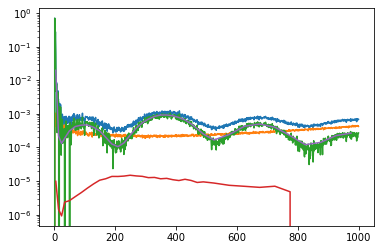

In [7]:
plt.plot(res_tot)
plt.plot(res_N)
plt.plot(res_tot-res_N)
plt.plot(np.mean(bins, axis=1), res_gal)
plt.plot(np.mean(bins, axis=1), smica_cmb_cl[0,0])
plt.yscale('log')

In [80]:
C_lS = io.load_powerspectra('signal')
print(C_lN.shape)
# Fakes the same shape so pw.build_covmatrices() may be used
C_lS_shaped = np.zeros_like(C_lN)
for freqcom in range(C_lS_shaped.shape[0]):
    for specidx in range(C_lS.shape[1]):
        C_lS_shaped[freqcom,specidx,:] = C_lS[0,specidx]
cov_lS = pw.build_covmatrices(C_lS_shaped, "K_CMB", csu.freqcomb, csu.PLANCKMAPFREQ_f)
print(cov_lS.shape)
cov_lSEE = cov_lS[1]
print(cov_lSEE.shape)

loaded /global/cscratch1/sd/sebibel/misc/C_lS_in_sim_id_0200.npy
(28, 9, 4001)
(9, 7, 7, 4001)
(7, 7, 4001)


In [79]:
%matplotlib widget
print(C_lS.shape)
n=0
plt.plot(cov_lS[3,n,n])
plt.show()
plt.yscale('log')

(1, 6, 4001)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
CMB = dict()
CMB["TQU"] = dict()
almT, almE, almB = dict(), dict(), dict()
maps = io.load_plamap(csu.cf, field=(0,1,2), nside_out=csu.nside_out)
tmask, pmask, pmask =  io.load_one_mask_forallfreq()
beamf = io.load_beamf(freqcomb=csu.freqcomb)

loaded {'030': '/global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/LFI_SkyMap_030_1024_R3.00_full.fits', '044': '/global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/LFI_SkyMap_044_1024_R3.00_full.fits', '070': '/global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/LFI_SkyMap_070_1024_R3.00_full.fits', '100': '/global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/HFI_SkyMap_100_2048_R3.01_full.fits', '143': '/global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/HFI_SkyMap_143_2048_R3.01_full.fits', '217': '/global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/HFI_SkyMap_217_2048_R3.01_full.fits', '353': '/global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/HFI_SkyMap_353_2048_R3.01_full.fits'}
loading mask ['psmaskP_2048.fits.gz', 'gmaskP_apodized_0_2048.fits.gz']


In [18]:
import component_separation.transform_map as trsf_m
maps = trsf_m.process_all(maps)

In [19]:
for freq in csu.PLANCKMAPFREQ_f:
    print('freq: ', freq)
    ns = csu.nside_out[0] if int(freq) < 100 else csu.nside_out[1]
    alms = pw.map2alm_spin(maps[freq], hp.ud_grade(pmask[freq], nside_out=ns), 2, lmax-1) # full sky QU->EB
    # almT[det] = alms[0]
    almE[freq] = alms[0]
    almB[freq] = alms[1]

nalm = int((lmax)*(lmax-1+2)/2)  
# combalmT = np.zeros((nalm), dtype=np.complex128)
combalmE = np.zeros((nalm), dtype=np.complex128)
combalmB = np.zeros((nalm), dtype=np.complex128)

freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [45]:
FREQ = "143"
mp100 = hp.alm2map([np.zeros_like(almE[FREQ]), almE[FREQ], almB[FREQ]], csu.nside_out[1])

In [47]:
hp.mollzoom(mp100[2], norm='hist')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
hp.mollview(mp100[2])

NameError: name 'mp100' is not defined

In [22]:
for it, det in enumerate(csu.PLANCKMAPFREQ): #weights do not depend on freqfilter, but almE/B do
    if det in csu.PLANCKMAPFREQ_f:
        print('freq: ', det)
        ns = csu.nside_out[0] if int(det) < 100 else csu.nside_out[1]
        # combalmT += hp.almxfl(almT[name], np.squeeze(W[0,m,:]))
        LHFI = "LFI" if int(det)<100 else "HFI"
        if csu.cf['pa']['freqdset'].startswith('NPIPE'):
            LHFI = "HFI"
        combalmE += hp.almxfl(hp.almxfl(almE[det],1/beamf[str(det)+'-'+str(det)][LHFI][1].data.field(1)[:lmax]), np.squeeze(W_total[1,it,:]))
        combalmE = hp.almxfl(combalmE, 1/hp.pixwin(ns, pol=True)[0][:lmax])
        combalmE = hp.smoothalm(combalmE, fwhm = np.radians(5/60))
        combalmB += hp.almxfl(hp.almxfl(almB[det],1/beamf[str(det)+'-'+str(det)][LHFI][1].data.field(2)[:lmax]), np.squeeze(W_total[1,it,:]))
        combalmB = hp.almxfl(combalmB, 1/hp.pixwin(ns, pol=True)[1][:lmax])
        combalmB = hp.smoothalm(combalmB, fwhm = np.radians(5/60))

freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [23]:
# smoothlm = hp.smoothalm([np.zeros_like(combalmE), combalmE, combalmB], fwhm=np.radians(80/60))
CMB["TQU"]['out'] = hp.alm2map([np.zeros_like(combalmE), combalmE, combalmB], csu.nside_out[1])

In [24]:
mv_cl = hp.alm2cl([np.zeros_like(combalmE), combalmE, combalmB])

(1e-18, 1e-14)

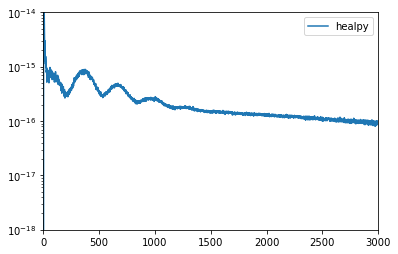

In [26]:
# mv_cl = hp.alm2cl([np.zeros_like(almE["217"]), almE["217"], almB["217"]])
plt.plot(mv_cl[1], label='healpy')
# plt.plot(cl_mv[0,1]*0.67, label='pospace', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.xlim((0,3000))
plt.ylim((1e-18,1e-14))
# plt.ylim((0,1))

In [107]:
%matplotlib widget
maq = hp.ma(CMB["TQU"]['out'][1])
maq.mask = np.logical_not(pmask['100'].astype(np.bool_))
hp.mollzoom(mau, norm='hist')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [108]:
%matplotlib widget
mau = hp.ma(CMB["TQU"]['out'][2])
mau.mask = np.logical_not(pmask['100'].astype(np.bool_))
# hp.mollview(mau, norm='hist')
hp.mollzoom(mau, norm='hist')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
cl_mv = pw.tqupowerspec({"100": CMB["TQU"]['out']}, pmask, pmask, csu.cf['pa']["lmax"], csu.cf['pa']["lmax_mask"], csu.nside_out, ["100-100"])

In [125]:
print(cl_mv.shape)

(1, 9, 4001)


In [49]:
hp.mollzoom(pure_cmb_map[1], norm= 'hist')
hp.mollzoom(pure_cmb_map[2], norm= 'hist')
hp.mollzoom(pure_cmb_map[0], norm= 'hist')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

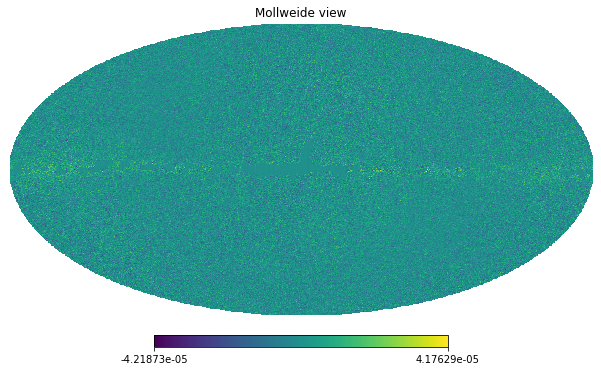

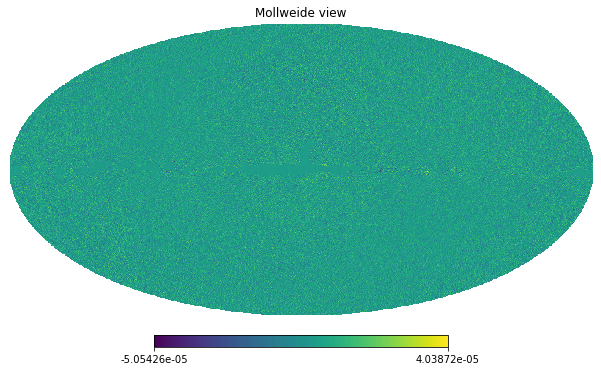

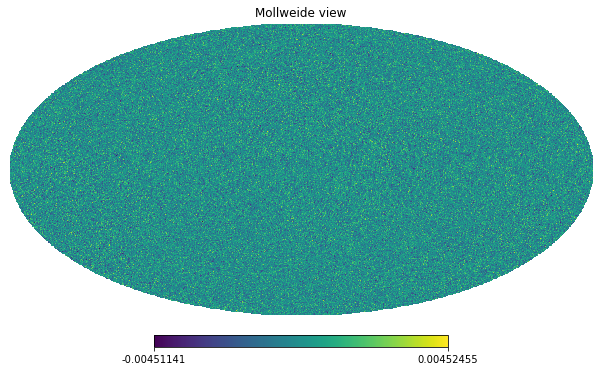

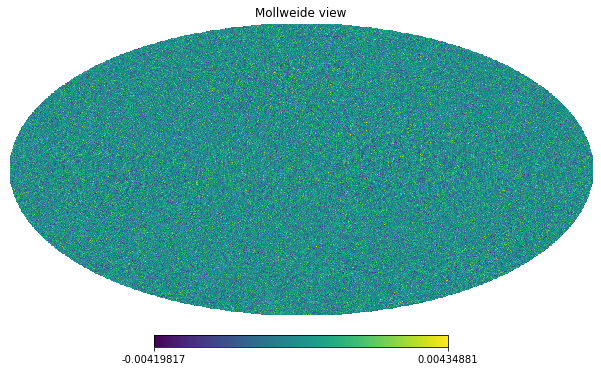

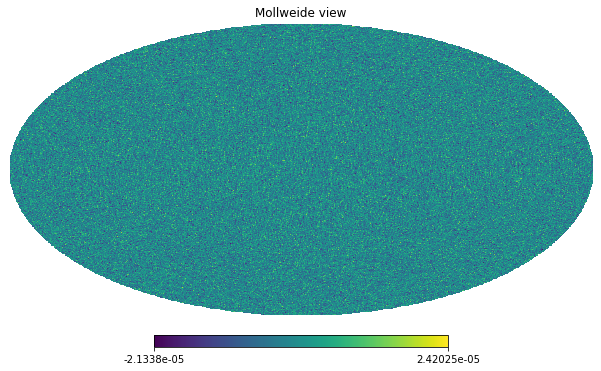

In [93]:
hp.mollview(MV_n[1])
hp.mollview(MV_n[2])
hp.mollview(CMB["TQU"]['out'][1])
hp.mollview(CMB["TQU"]['out'][2])

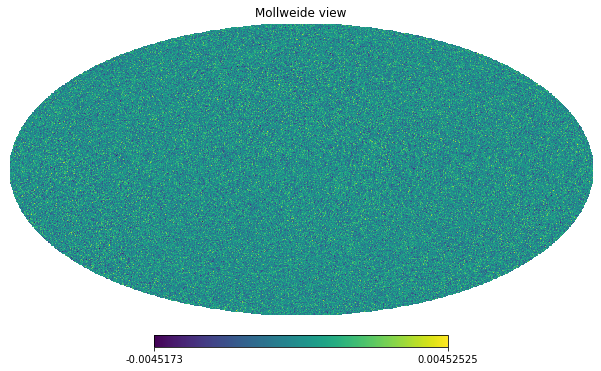

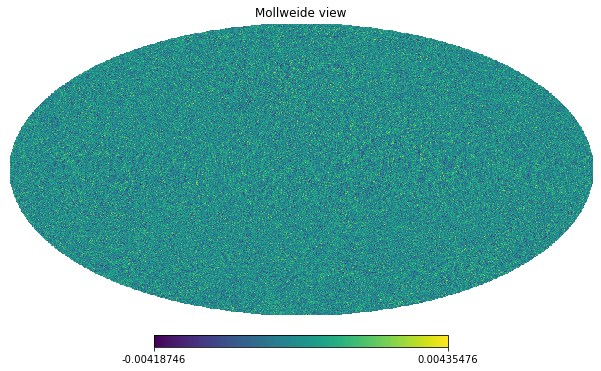

In [94]:
residual_map = CMB["TQU"]['out']-pure_cmb_map
hp.mollview(residual_map[1])
hp.mollview(residual_map[2])

In [109]:
cmb_tlm, cmb_elm, cmb_blm = cslib.load_alms('cmb', csu.sim_id)
residual_cl = np.array([np.zeros(shape=combalmE.shape), combalmE-cmb_elm[:8002000],combalmB-cmb_blm[:8002000]])
# residual_cl = hp.anafast(residual_map)

In [112]:
res_cl = hp.alm2cl(residual_cl)
print(res_cl.shape)
cl1 = hp.alm2cl([cmb_tlm, cmb_elm, cmb_blm])
cl2 = hp.alm2cl([np.zeros_like(combalmE),combalmE, combalmB])

(6, 4000)


(0.0, 1000.0)

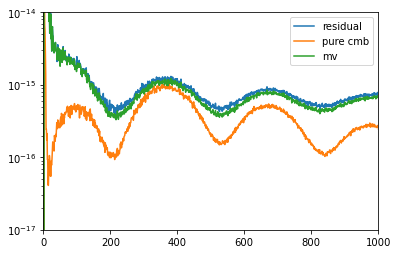

In [114]:
plt.plot(res_cl[1], label= 'residual')
plt.plot(cl1[1], label='pure cmb')
plt.plot(cl2[1], label='mv')
plt.yscale('log')
plt.legend()
plt.ylim((1e-17,1e-14))
plt.xlim((0,1000))

(0.0, 1000.0)

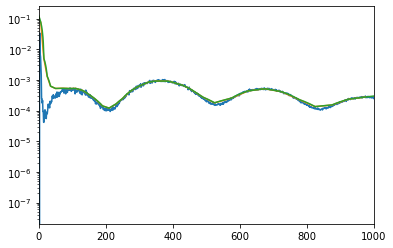

In [86]:
plt.plot(pure_cmb_cl[0,1])
plt.plot(np.mean(bins, axis=1), smica_cmb_cl[0,0])
plt.plot(smica_cmb_cl_interp(xnew))
plt.yscale('log')

plt.xlim((0,1000))

In [48]:
xnew = np.arange(0,lmax+1,1)
smica_cmb_cl_interp = interpolate.interp1d(np.mean(bins, axis=1), smica_cmb_cl[0,0], bounds_error = False, fill_value='extrapolate')

In [50]:
smica_cmb_map = hp.synfast(smica_cmb_cl_interp(xnew), nside=2048)
pure_cmb_map = hp.synfast(cmb_cl[0,1], nside=2048)

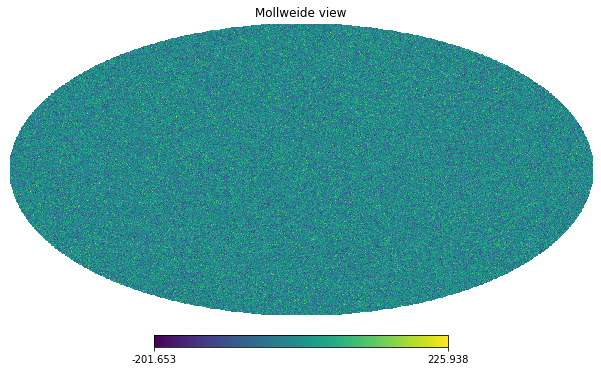

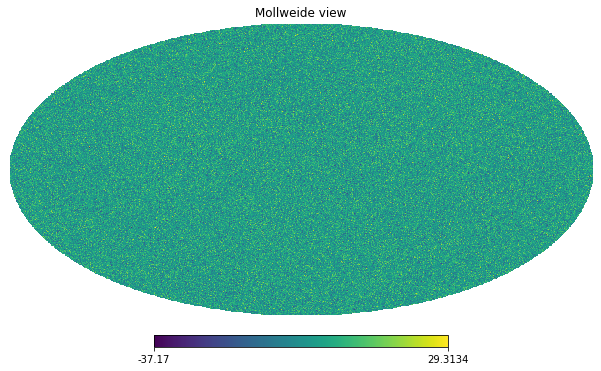

In [51]:
hp.mollview(smica_cmb_map)
hp.mollview(pure_cmb_map)

In [2]:
import component_separation.transform_spec as trsf_s
beamf = io.load_beamf(csu.freqcomb)
data = io.load_data(io.fh.spec_unsc_path_name)
data = trsf_s.apply_beamfunction(data, beamf, csu.freqcomb)


loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE/SPEC-RAW_0200_C_l_NPIPE_smica_4000_6000_Full.npy


['030-030', '030-044', '030-070', '030-100', '030-143', '030-217', '030-353', '044-044', '044-070', '044-100', '044-143', '044-217', '044-353', '070-070', '070-100', '070-143', '070-217', '070-353', '100-100', '100-143', '100-217', '100-353', '143-143', '143-217', '143-353', '217-217', '217-353', '353-353']


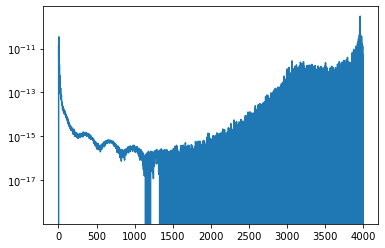

In [16]:
for n in range(len(data)):
    for m in range(9):
        if n==20 and m==1:
            plt.plot(data[n,m])
print(csu.freqcomb)
plt.yscale('log')

In [10]:
print(data[8,1])

[0.00000000e+00 0.00000000e+00 3.36925091e-12 ... 7.24492825e-09
 6.91377366e-09 6.71749991e-09]
